In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from torch.autograd.gradcheck import gradcheck
from torch.autograd import Variable
import os
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# from utils import plot_images

Preprocessing and loading dataset


In [2]:
#preprocessing
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#transform image data
train_set= datasets.ImageFolder(root='img/train', transform = transformations)
val_set = datasets.ImageFolder(root='img/val', transform = transformations)
test_set=datasets.ImageFolder(root='img/test', transform = transformations)

#load image data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =64, shuffle=True)


Visualising images

In [3]:
#visualize images
def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)
    label_names=['indoor','outdoor']
    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


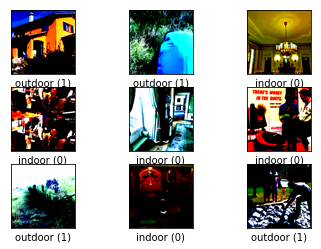

In [4]:
#create a random sub sample of data
num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(1000 * num_train))
batch_size=64
shuffle=True
if True:
    np.random.seed(20)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# visualize some images
if True:
    sample_loader = torch.utils.data.DataLoader(
        train_set, batch_size=9, shuffle=shuffle,
        
    )
    data_iter = iter(sample_loader)
    images, labels = data_iter.next()
#     print(image.size())
    X = np.transpose(images,[0, 2, 3, 1])
#     print(X.shape)
    plot_images(X, labels)



Loading model

In [5]:
#load pretrained model
model = models.vgg16(pretrained=True)

#turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

Modify model classifier

In [6]:
#modify classifier to fit binary classification
classifier = nn.Sequential(nn.Linear(25088, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))
model.classifier = classifier

Load model on device

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Set negative log likelihood loss and optimizer

In [8]:
loss_criteria = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

Training the classifier

In [10]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])

epochs = 10
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # clear optimizers
        optimizer.zero_grad()
        # forward pass
        output = model.forward(inputs)
        print(output.size())
        # loss
        loss = loss_criteria(output, labels)
        # calculate gradients
        loss.backward()
        #unit test to check gradients
#       test = gradcheck(model, (input))
#         print(test)
        # adjust parameters
        optimizer.step()
        # add loss to the training set's running loss
        train_loss += loss.item()*inputs.size(0)
        
        # print the training progress 
        counter += 1
        print(counter, "/", len(train_loader),train_loss)
        
    # Evaluating the model


    model.eval()
    counter = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)

            valloss = loss_criteria(output, labels)
            val_loss += valloss.item()*inputs.size(0)

            output = torch.exp(output)
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)

            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            counter += 1
            print(counter, "/", len(val_loader))

    # average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)

    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))



torch.Size([64, 2])
1 / 121 2.423365592956543
torch.Size([64, 2])
2 / 121 7.102744102478027
torch.Size([64, 2])
3 / 121 9.980819940567017
torch.Size([64, 2])
4 / 121 11.673376083374023
torch.Size([64, 2])
5 / 121 17.57026720046997
torch.Size([64, 2])
6 / 121 19.18695330619812
torch.Size([64, 2])
7 / 121 21.460609197616577
torch.Size([64, 2])
8 / 121 23.613799810409546
torch.Size([64, 2])
9 / 121 30.21833300590515
torch.Size([64, 2])
10 / 121 36.394328355789185
torch.Size([64, 2])
11 / 121 41.126574754714966
torch.Size([64, 2])
12 / 121 47.199140787124634
torch.Size([64, 2])
13 / 121 47.83518970012665
torch.Size([64, 2])
14 / 121 49.09141170978546
torch.Size([64, 2])
15 / 121 92.60331356525421
torch.Size([64, 2])
16 / 121 96.06733787059784
torch.Size([64, 2])
17 / 121 99.3695832490921
torch.Size([64, 2])
18 / 121 99.47687703371048
torch.Size([64, 2])
19 / 121 108.29324322938919
torch.Size([64, 2])
20 / 121 112.0337193608284
torch.Size([64, 2])
21 / 121 114.14976888895035
torch.Size([64,

torch.Size([64, 2])
47 / 121 59.64021986722946
torch.Size([64, 2])
48 / 121 59.67178386449814
torch.Size([64, 2])
49 / 121 59.69173687696457
torch.Size([64, 2])
50 / 121 62.4077450633049
torch.Size([64, 2])
51 / 121 62.409899175167084
torch.Size([64, 2])
52 / 121 62.420147597789764
torch.Size([64, 2])
53 / 121 62.66811627149582
torch.Size([64, 2])
54 / 121 63.067567586898804
torch.Size([64, 2])
55 / 121 63.3762092590332
torch.Size([64, 2])
56 / 121 63.884151220321655
torch.Size([64, 2])
57 / 121 64.43696683645248
torch.Size([64, 2])
58 / 121 64.44951575994492
torch.Size([64, 2])
59 / 121 64.67477661371231
torch.Size([64, 2])
60 / 121 64.72278434038162
torch.Size([64, 2])
61 / 121 64.72629648447037
torch.Size([64, 2])
62 / 121 67.48236781358719
torch.Size([64, 2])
63 / 121 67.48618561029434
torch.Size([64, 2])
64 / 121 67.50395673513412
torch.Size([64, 2])
65 / 121 67.52001506090164
torch.Size([64, 2])
66 / 121 68.03305947780609
torch.Size([64, 2])
67 / 121 68.53301298618317
torch.Size(

torch.Size([64, 2])
94 / 121 57.56770145893097
torch.Size([64, 2])
95 / 121 59.35317933559418
torch.Size([64, 2])
96 / 121 59.355157256126404
torch.Size([64, 2])
97 / 121 59.35547363758087
torch.Size([64, 2])
98 / 121 60.10500741004944
torch.Size([64, 2])
99 / 121 60.10503935813904
torch.Size([64, 2])
100 / 121 60.10530948638916
torch.Size([64, 2])
101 / 121 60.76411020755768
torch.Size([64, 2])
102 / 121 60.89628738164902
torch.Size([64, 2])
103 / 121 61.87326139211655
torch.Size([64, 2])
104 / 121 61.910350263118744
torch.Size([64, 2])
105 / 121 62.21503072977066
torch.Size([64, 2])
106 / 121 62.947525441646576
torch.Size([64, 2])
107 / 121 62.97762840986252
torch.Size([64, 2])
108 / 121 66.76534670591354
torch.Size([64, 2])
109 / 121 66.76744431257248
torch.Size([64, 2])
110 / 121 66.76800507307053
torch.Size([64, 2])
111 / 121 66.7685016989708
torch.Size([64, 2])
112 / 121 67.53736889362335
torch.Size([64, 2])
113 / 121 70.08549177646637
torch.Size([64, 2])
114 / 121 70.08681213855

torch.Size([64, 2])
14 / 121 10.325290381908417
torch.Size([64, 2])
15 / 121 15.634058654308319
torch.Size([64, 2])
16 / 121 15.709107220172882
torch.Size([64, 2])
17 / 121 15.817900359630585
torch.Size([64, 2])
18 / 121 15.835202157497406
torch.Size([64, 2])
19 / 121 15.837747037410736
torch.Size([64, 2])
20 / 121 15.927805721759796
torch.Size([64, 2])
21 / 121 16.403359919786453
torch.Size([64, 2])
22 / 121 16.91879966855049
torch.Size([64, 2])
23 / 121 16.939630180597305
torch.Size([64, 2])
24 / 121 19.662466675043106
torch.Size([64, 2])
25 / 121 19.70566287636757
torch.Size([64, 2])
26 / 121 20.400197714567184
torch.Size([64, 2])
27 / 121 23.17502424120903
torch.Size([64, 2])
28 / 121 23.576917201280594
torch.Size([64, 2])
29 / 121 23.594699770212173
torch.Size([64, 2])
30 / 121 24.314873844385147
torch.Size([64, 2])
31 / 121 24.504906505346298
torch.Size([64, 2])
32 / 121 24.534378975629807
torch.Size([64, 2])
33 / 121 25.486901849508286
torch.Size([64, 2])
34 / 121 25.74587312340

60 / 121 34.26306450366974
torch.Size([64, 2])
61 / 121 34.98857390880585
torch.Size([64, 2])
62 / 121 36.26429724693298
torch.Size([64, 2])
63 / 121 36.83991730213165
torch.Size([64, 2])
64 / 121 36.847355246543884
torch.Size([64, 2])
65 / 121 36.84766972064972
torch.Size([64, 2])
66 / 121 36.86292803287506
torch.Size([64, 2])
67 / 121 36.88020431995392
torch.Size([64, 2])
68 / 121 36.990702390670776
torch.Size([64, 2])
69 / 121 36.99941873550415
torch.Size([64, 2])
70 / 121 36.99979567527771
torch.Size([64, 2])
71 / 121 37.00034213066101
torch.Size([64, 2])
72 / 121 37.05490446090698
torch.Size([64, 2])
73 / 121 37.05571532249451
torch.Size([64, 2])
74 / 121 37.05615448951721
torch.Size([64, 2])
75 / 121 38.208107590675354
torch.Size([64, 2])
76 / 121 42.33812344074249
torch.Size([64, 2])
77 / 121 42.33826458454132
torch.Size([64, 2])
78 / 121 42.33863437175751
torch.Size([64, 2])
79 / 121 43.39202558994293
torch.Size([64, 2])
80 / 121 43.392220854759216
torch.Size([64, 2])
81 / 121 

106 / 121 46.00758081674576
torch.Size([64, 2])
107 / 121 47.32412439584732
torch.Size([64, 2])
108 / 121 47.74836269021034
torch.Size([64, 2])
109 / 121 47.7501622736454
torch.Size([64, 2])
110 / 121 52.614657551050186
torch.Size([64, 2])
111 / 121 52.61516919732094
torch.Size([64, 2])
112 / 121 52.61577859520912
torch.Size([64, 2])
113 / 121 52.62849906086922
torch.Size([64, 2])
114 / 121 52.69860062003136
torch.Size([64, 2])
115 / 121 55.67544063925743
torch.Size([64, 2])
116 / 121 55.764484614133835
torch.Size([64, 2])
117 / 121 56.16534420847893
torch.Size([64, 2])
118 / 121 58.454988688230515
torch.Size([64, 2])
119 / 121 60.10763856768608
torch.Size([64, 2])
120 / 121 61.581307500600815
torch.Size([61, 2])
121 / 121 64.41951552405953
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22
14 / 22
15 / 22
16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22
22 / 22
Accuracy:  0.9893465909090909
Epoch: 6 	Training Loss: 0.008322 	Validation Loss: 

26 / 121 83.08574575185776
torch.Size([64, 2])
27 / 121 85.10045951604843
torch.Size([64, 2])
28 / 121 85.12936681509018
torch.Size([64, 2])
29 / 121 85.14936643838882
torch.Size([64, 2])
30 / 121 85.34686237573624
torch.Size([64, 2])
31 / 121 85.35401254892349
torch.Size([64, 2])
32 / 121 85.5375674366951
torch.Size([64, 2])
33 / 121 85.65502554178238
torch.Size([64, 2])
34 / 121 90.48742204904556
torch.Size([64, 2])
35 / 121 90.78757375478745
torch.Size([64, 2])
36 / 121 90.81461209058762
torch.Size([64, 2])
37 / 121 97.69044989347458
torch.Size([64, 2])
38 / 121 97.97394144535065
torch.Size([64, 2])
39 / 121 97.97397005558014
torch.Size([64, 2])
40 / 121 98.3193689584732
torch.Size([64, 2])
41 / 121 98.32273638248444
torch.Size([64, 2])
42 / 121 98.33527290821075
torch.Size([64, 2])
43 / 121 98.3389014005661
torch.Size([64, 2])
44 / 121 101.19612658023834
torch.Size([64, 2])
45 / 121 101.92560184001923
torch.Size([64, 2])
46 / 121 102.01885890960693
torch.Size([64, 2])
47 / 121 102.

torch.Size([64, 2])
72 / 121 47.05321103334427
torch.Size([64, 2])
73 / 121 49.607060730457306
torch.Size([64, 2])
74 / 121 49.99963602423668
torch.Size([64, 2])
75 / 121 51.257927507162094
torch.Size([64, 2])
76 / 121 51.35547158122063
torch.Size([64, 2])
77 / 121 51.43097206950188
torch.Size([64, 2])
78 / 121 51.47000262141228
torch.Size([64, 2])
79 / 121 53.79064556956291
torch.Size([64, 2])
80 / 121 53.7961046397686
torch.Size([64, 2])
81 / 121 53.79720422625542
torch.Size([64, 2])
82 / 121 53.80549880862236
torch.Size([64, 2])
83 / 121 53.805967062711716
torch.Size([64, 2])
84 / 121 53.913689345121384
torch.Size([64, 2])
85 / 121 53.91882273554802
torch.Size([64, 2])
86 / 121 54.80370166897774
torch.Size([64, 2])
87 / 121 54.812226086854935
torch.Size([64, 2])
88 / 121 54.812881261110306
torch.Size([64, 2])
89 / 121 54.85653641819954
torch.Size([64, 2])
90 / 121 55.68545737862587
torch.Size([64, 2])
91 / 121 57.18242171406746
torch.Size([64, 2])
92 / 121 57.18432334065437
torch.Si

Processing a single image and predicting class using model

In [15]:
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [16]:
def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()


In [17]:
def show_image(image):

    image = image.numpy()
    image[0] = image[0] * 0.226 + 0.445
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image has a predicted class of  outdoor


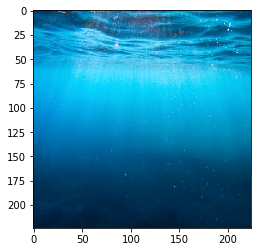

In [22]:
image = process_image("img/test/outdoor/water.jpg")
top_prob, top_class = predict(image, model)
if top_class== 0:
    top='indoor'
else:
    top='outdoor'
show_image(image)
print("Image has a predicted class of ", top)
